In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import random
import os
from collections import defaultdict
from sklearn.metrics import f1_score

In [ ]:
class_df = pd.read_csv('Elliptic++Dataset/txs_classes.csv')
feature_df = pd.read_csv('Elliptic++Dataset/txs_features.csv')
edgelist_df = pd.read_csv('Elliptic++Dataset/txs_edgelist.csv')
     

In [4]:
print(feature_df.values.tolist()[0])

[3321.0, 1.0, -0.1696145998853753, -0.1846675514329143, -1.2013688016765636, -0.1219695997591005, -0.0438745479173489, -0.1130020092847624, -0.0615837940730322, -0.1601991787299934, -0.1660620004567307, -0.0497069643940398, -0.1625066699069773, -0.0287412858566647, -0.0353905526008135, -0.0429552992580282, -0.0132816148700588, -0.0421833194367385, -0.1687699606730488, -0.1714162390000508, -0.1722767922969639, -1.373657177393896, -1.37145982760274, -0.1396632631031901, -0.1488685358891392, -0.0801472696533522, -0.1556038568434534, -0.010763009512837, -0.0121074517774784, -0.1396650530368671, -0.1488638323832784, -0.0801467358465918, -0.1556038211055125, -0.0106685610738475, -0.0120051821184178, -0.0246681218823163, -0.0312717264762497, -0.0230451563960962, -0.0262139644326344, 0.0014278137097094, 0.0014826437872997, -0.2262977210157964, -0.238504274476095, -0.0752555315462277, -0.2340532466751961, 0.0374680287743863, 0.0434442213339417, -0.2266814301151297, -0.2427256267169767, -0.09789

In [ ]:
def load_data():
    feature=feature_df
    record_num=feature.shape[0]
    feature_num= 165
    nodes_num=record_num+1

    m_feature=np.zeros((nodes_num,feature_num))
    labels=np.zeros((nodes_num,1))
    
   
    node2idx={}  #node2idx[paper_id]->index
    label2idx={}

    for i, data in enumerate(zip(feature_df.values.tolist(), class_df.values.tolist()[1:])):
        m_feature[i,:]=data[0][2:]
        node2idx[data[0][0]]=i
        class_ = data[1]
        if class_[-1] not in label2idx.keys():
            label2idx[class_[-1]]=len(label2idx)
        labels[i]=label2idx[class_[-1]]

    adj=defaultdict(set)
    for row in edgelist_df.values.tolist() :
        a,b=node2idx[row[0]],node2idx[row[1]]
        adj[a].add(b)
        adj[b].add(a)

    return m_feature,labels,adj

[(-0.1696145998853753, 0), (-0.1375859782492397, 1), (-0.1701032099368012, 2), (-0.1142667459350472, 3), (5.20210716810059, 4), (-0.1702839420509306, 5), (-0.1386184353345738, 6), (0.2298447688705227, 7), (-0.1237070342765169, 8), (-0.171722416771246, 112616), (-0.1711531133870703, 10), (-0.1727261173847863, 11), (-0.1386568418864999, 12), (0.5811196739225214, 13), (-0.1726931520596082, 93846), (-0.1174306222719627, 15), (-0.171640000020674, 16), (0.3234518654461698, 17), (-0.1718946392772864, 18), (0.0604797254694478, 19), (-0.1723980873865879, 20), (-0.1729116463441362, 3302), (-0.1729208553988536, 202838), (-0.1477040668945682, 23), (-0.1729080422607287, 24), (-0.1699665354542572, 25), (-0.1718773244252219, 26), (-0.172875244590807, 27), (-0.1445638216858905, 28), (-0.0132677646780803, 29), (-0.1445981725322737, 30), (-0.1661376605979787, 31), (-0.1713832334093462, 32), (-0.1718012785113185, 33), (-0.1709608370290198, 34), (-0.1716876153119389, 35), (0.314084185770468, 36), (-0.1609

KeyError: 230425980

In [9]:
class Aggregator(nn.Module):
    def __init__(self,features,aggr_method="mean"):
     
        super(Aggregator,self).__init__()
        self.features=features
        self.aggr_method=aggr_method
    
    def forward(self,nodes,neighs,num_sample=10):
  
        result=[]
        for i,adj_node in enumerate(neighs):
            if len(adj_node)>=num_sample:
                temp=random.sample(list(adj_node),num_sample)
            else:
                temp=adj_node
            result.append(set(temp))
        '''
        result=[]
        for i,adj_node in enumerate(neighs):
            temp=np.random.choice(list(adj_node),num_sample，replacement=True)
            result.append(set(temp))
        '''
  
        unique_nodes_list=list(set.union(*result))
        unique_nodes={n:i for i,n in enumerate(unique_nodes_list)}
    
        mask = Variable(torch.zeros(len(result), len(unique_nodes)))
        column_indices = [unique_nodes[n] for temp in result for n in temp]   
        row_indices = [i for i in range(len(result)) for j in range(len(result[i]))]
        mask[row_indices, column_indices] = 1
        if(self.aggr_method=="mean"):
            num_neigh = mask.sum(1, keepdim=True)
            mask = mask.div(num_neigh)
        if(self.aggr_method=="sum"):
            mask=mask
  
        embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
        print(embed_matrix.shape)
        feats = mask.mm(embed_matrix)
        return feats

In [10]:
class GraphSage(nn.Module):
    def __init__(self,features,adj_table,input_dim,embed_dim,aggregator,num_sample=10):
        super(GraphSage,self).__init__()
        
        self.features=features
        self.aggregator=aggregator
        self.num_sample=num_sample
        self.adj_table=adj_table
        self.input_dim=input_dim
        self.embed_dim=embed_dim
        
        self.weight=nn.Parameter(torch.FloatTensor(embed_dim,2*input_dim))
        init.xavier_uniform_(self.weight)
    
    def forward(self,nodes):

        neighs=[]
        for node in nodes:
            neighs.append(self.adj_table[node])
        n_feature=self.aggregator.forward(nodes,neighs,self.num_sample)
        self_feature=self.features(torch.LongTensor(nodes))
        combined=torch.cat([self_feature,n_feature],dim=1)
        
        return F.relu(self.weight.mm(combined.t()))

In [11]:
def data_split(num_nodes):
    random_idx=np.random.permutation(num_nodes)
    train,val=random_idx[:int(num_nodes/10*9)],random_idx[int(num_nodes/10*9):]
    return train,val

In [13]:

class predict(nn.Module):
    def __init__(self,model,num_class):
        super(predict,self).__init__()
        self.model=model
        self.weight=nn.Parameter(torch.FloatTensor(num_class,model.embed_dim))
    
        init.xavier_uniform_(self.weight)
    
    def forward(self,nodes):

        hidden=self.model(nodes)
        return self.weight.mm(hidden)

In [14]:

def early_stop(accuracy_list,index,difference):
    if index>=1:
        if((accuracy_list[index-1]-accuracy_list[index])>difference):
            return True
    return False

In [15]:

def accuracy(labels,predict):

    case=0
    node_num=labels.shape[0]
    for i,classes in enumerate(labels):
        if(labels[i]==predict[i]):
            case=case+1
    return case/node_num

In [16]:
batch_size=300
embedding_dim=128
learning_rate=0.001
difference=0.05
epoch=40
num_classes=3
features_data,labels,adj_table=load_data()
(a,b)=features_data.shape

features=nn.Embedding(a,b)
features.weight=nn.Parameter(torch.FloatTensor(features_data),requires_grad=False)

aggregator=Aggregator(features,aggr_method="sum")
Layer=GraphSage(features,adj_table,b,embedding_dim,aggregator)


predict_classes=predict(Layer, num_classes)


loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(predict_classes.parameters(),lr=learning_rate)


train,val=data_split(int(a))

epoch_record=[]
loss_record=[]
accuracy_record=[]
micro_f1=[]
illicit_f1_arr = []
for i in range(epoch):
    random.shuffle(train)
    nodes=train[:batch_size]
    optimizer.zero_grad()
    predict_result=predict_classes(nodes).t()
    loss=loss_fn(predict_result,torch.LongTensor(labels[nodes].squeeze()))
    loss.backward()
    optimizer.step()
    # print("epoch:",i,"loss:",loss.item())
    epoch_record.append(i)
    loss_record.append(loss.item())
    accuracy_record.append(accuracy(labels[val].squeeze(),predict_classes(val).data.numpy().argmax(axis=0)))
    #illicit_f1_arr.append(f1_score(labels[val].squeeze(),predict_classes(val).data.numpy().argmax(axis=0),average=None))
    micro_f1.append(f1_score(labels[val].squeeze(),predict_classes(val).data.numpy().argmax(axis=0),average="micro"))
    if(early_stop(accuracy_record,i,difference)==True):
        break
    
ground_truth=labels[val].squeeze()
final_predict=predict_classes(val).data.numpy().argmax(axis=0)
print("Accuracy:",accuracy(ground_truth,final_predict))
print("F1 score:",f1_score(ground_truth,final_predict,average="micro"))
print("Current epoch:",i)
     

ValueError: could not broadcast input array from shape (182,) into shape (165,)

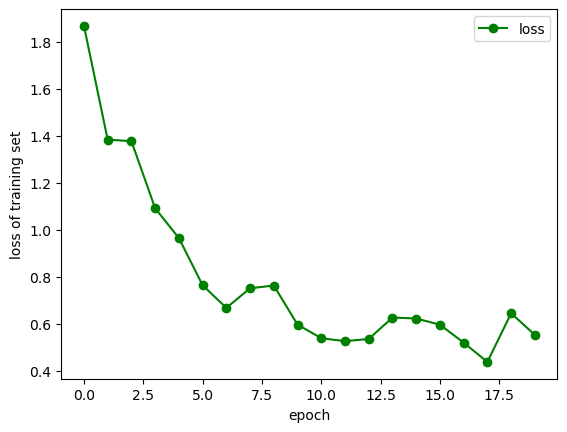

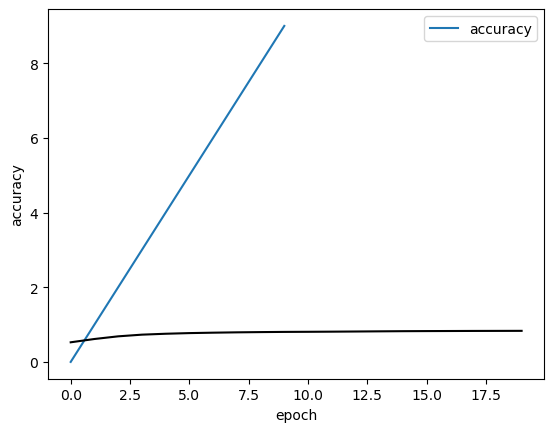

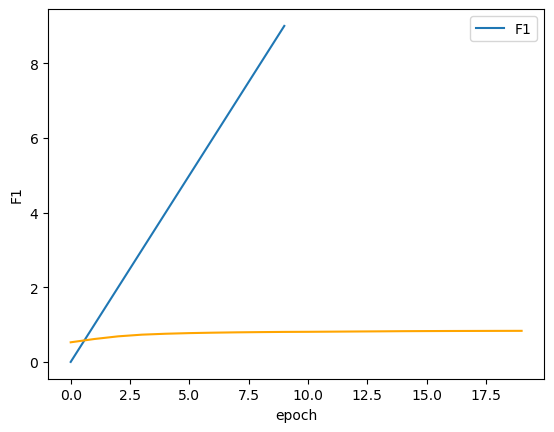

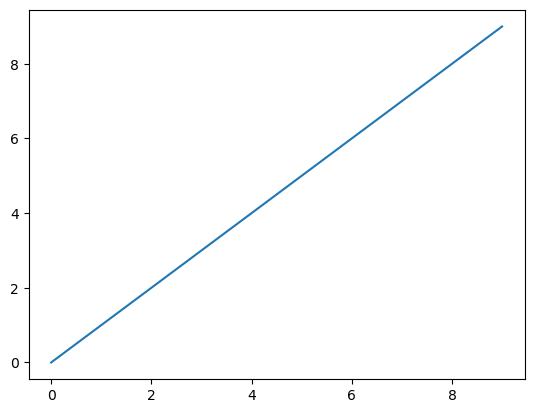

In [13]:

plt.plot(epoch_record,loss_record,marker='o',color='green')
plt.xlabel("epoch")
plt.ylabel("loss of training set")
plt.legend(["loss"])
plt.show()
fig1 = plt.figure()
plt.plot(range(10))
fig1.savefig('losstrain.png', dpi=fig1.dpi)
plt.plot(epoch_record,accuracy_record,color='black')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["accuracy"])
plt.show()
fig2 = plt.figure()
plt.plot(range(10))
fig2.savefig('accuracy.png', dpi=fig2.dpi)
plt.plot(epoch_record,micro_f1,color='orange')
plt.xlabel("epoch")
plt.ylabel("F1")
plt.legend(["F1"])
plt.show()
fig3 = plt.figure()
plt.plot(range(10))
fig3.savefig('epoch.png', dpi=fig3.dpi)